## MusicNet

In [1]:
MUSICNET_DIR = "musicnet"

## Load data

In [2]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchaudio
from scipy.io import wavfile
from torchaudio.compliance import kaldi
from tqdm.auto import tqdm


def sample_to_frames(
    t_sample,
    frame_size=10, # ms / frame
    sampling_rate=44100
):
    t_sec = t_sample / sampling_rate  # (sample) / (sample / sec)
    t_frame = t_sec / (frame_size / 1000) # (sec) / (sec / 1000*frame)
    return int(t_frame)


def get_data(set_name="train", n_notes=88):
    # check if set_name is valid or not
    if set_name.lower().strip() not in ["train", "test"]:
        raise NameError(f"Unrecognized set name: {set_name}")
    
    wav_paths = sorted(glob(f"{MUSICNET_DIR}/{set_name}_data/**/*.wav", recursive=True))
    csv_paths = [wav.replace("_data", "_labels").replace(".wav", ".csv") for wav in wav_paths]
    assert all(os.path.exists(csv) for csv in csv_paths)
    
    data = []
    for wav_path, csv_path in tqdm(zip(wav_paths, csv_paths), total=len(wav_paths)):
        wav, sr = torchaudio.load(wav_path)
        # config feature here
        fbank = kaldi.fbank(wav, sample_frequency=sr, num_mel_bins=120, frame_length=30)
        
        label = pd.read_csv(csv_path)
        y = np.zeros([fbank.shape[0], n_notes])
        for  i, row in label.iterrows():
            y[sample_to_frames(row["start_time"]):sample_to_frames(row["end_time"]), row["note"] - 20] = 1
            
        data.append({"wav_path": wav_path, "label": y, "feature": fbank})
    
    return data

In [3]:
train = get_data("train")
test = get_data("test")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Preprocess (split+pad)

In [139]:
MAX_LEN = 15  # seconds

In [235]:
def trim_front_label(x):
    """x is 2darray"""
    for i in range(x.shape[0]):
        if x[i].sum() == 0:
            continue
        else:
            break
    
    return i, x[i:]
            

def trim_data(feature, label):
    """Trim wav/label where got no notes
    """
    
    idx, trimmed_front_label = trim_front_label(label)
    trimmed_front_feature = feature[idx:]
    
    rev_feature = trimmed_front_feature[::-1]
    rev_label = trimmed_front_label[::-1]
    
    idx, trimmed_label = trim_front_label(rev_label)
    trimmed_feature = rev_feature[idx:]
    return trimmed_feature[::-1], trimmed_label[::-1]


def preprocess_set(data, max_len, trim=True):
    dataset = {}
    max_len = max_len * 100  # frame size 10 ms
    for item in tqdm(data):
        # unpack
        feature, label = item["feature"].numpy(), item["label"]
        name = os.path.basename(item["wav_path"]).split(".")[0]
        
        # trim silences
        if trim:
            feature, label = trim_data(feature, label)
        
        seq_len = feature.shape[0] 
        n_samples = int(seq_len / max_len) + 1  # ceil
        
        # iterate over chunks
        for i in range(n_samples):
            start_idx = i*max_len
            end_idx = min(start_idx + max_len, feature.shape[0])
            
            x_chunk = feature[start_idx:end_idx]
            y_chunk = label[start_idx:end_idx]
            
            if x_chunk.shape[0] != max_len:
                # pad remainders, will skip for now
                continue
                
            if name not in dataset.keys():
                dataset[name] = []
            dataset[name].append({
                "feature": x_chunk,
                "label": y_chunk
            })
                
    return dataset

In [236]:
train_data = preprocess_set(train, MAX_LEN)
test_data = preprocess_set(test, MAX_LEN)

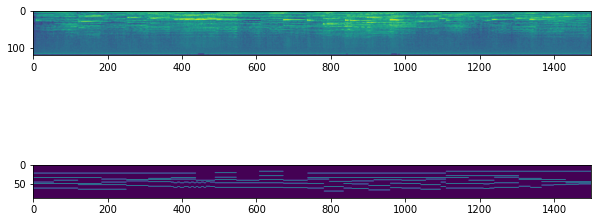

In [249]:
data_id = "1727"
item_no = 0

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].imshow(train_data[data_id][item_no]["feature"].T)
ax[1].imshow(train_data[data_id][item_no]["label"].T)

In [261]:
def dump_dataset(data, save_path):
    os.makedirs(os.path.join(save_path, "feat"), exist_ok=True)
    os.makedirs(os.path.join(save_path, "label"), exist_ok=True)
    for name, d in data.items():
        for i, item in enumerate(d):
            with open(f"{save_path}/feat/{name}-{i:02d}.npy", "wb") as f:
                np.save(f, item["feature"].astype(np.float32))
                
            with open(f"{save_path}/label/{name}-{i:02d}.npy", "wb") as f:
                np.save(f, item["label"].astype(np.float32))
    

In [ ]:
dump_dataset(train_data, "processed_dataset")
dump_dataset(test_data, "processed_dataset")

In [263]:
!du -h processed_dataset

5.3G	processed_dataset/feat
3.9G	processed_dataset/label
9.2G	processed_dataset
